In [6]:
import sqlite3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [7]:
conn = sqlite3.connect("../../places.sqlite")

full_data = pd.read_sql_query(
    """
SELECT 
    moz_places.url as url,
    moz_places.visit_count as visit_count,
    moz_places.frecency as url_frecency,
    moz_places.last_visit_date as last_visit_date,
    moz_origins.host as host,
    moz_origins.frecency as host_frecency
FROM moz_places
    JOIN moz_origins on moz_places.origin_id = moz_origins.id
    WHERE last_visit_date != 'NULL';
""",
    conn,
)

origins_data = pd.read_sql_query(
    """
SELECT
    moz_origins.host as host,
    moz_origins.frecency as host_frecency
FROM moz_origins;
""",
    conn,
)
full_data[full_data["visit_count"] == 0] = 1


In [8]:
from datetime import datetime

full_data["last_visit_date_obj"] = full_data["last_visit_date"].map(
    lambda x: datetime.fromtimestamp(x / 1000000)
)


In [9]:
full_data.head()


,url,visit_count,url_frecency,last_visit_date,host,host_frecency,last_visit_date_obj
0,https://spins.fedoraproject.org/,8,235,1683703131549000,spins.fedoraproject.org,2163,2023-05-10 07:18:51.549000
1,https://www.redhat.com/,1,20,1686205766649115,www.redhat.com,14741,2023-06-08 06:29:26.649115
2,https://www.wikipedia.org/,5,1614,1694502232693589,www.wikipedia.org,3947,2023-09-12 07:03:52.693589
3,https://www.mozilla.org/en-US/privacy/firefox/,2,20,1685958651538450,www.mozilla.org,222,2023-06-05 09:50:51.538450
4,https://addons.mozilla.org/en-US/firefox/searc...,1,20,1685958696631130,addons.mozilla.org,58507,2023-06-05 09:51:36.631130


In [10]:
print("full_data: ", len(set(full_data["host"].unique())))
print("origins_data: ", len(set(origins_data["host"].unique())))

# view intersection of the two dataframes

x = set(origins_data["host"].unique().tolist()).difference(
    set(full_data["host"].unique().tolist())
)

print(len(x))


full_data:  2196
origins_data:  2293
98


In [11]:
modified_data = pd.DataFrame()
modified_data = origins_data

modified_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   host           2530 non-null   object
 1   host_frecency  2530 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.7+ KB


In [12]:
modified_data.head()


,host,host_frecency
0,type=6&sort=14&maxResults=10,0
1,docs.fedoraproject.org,1438
2,fedoramagazine.org,360
3,getfedora.org,140
4,spins.fedoraproject.org,2163


In [13]:
visit_counts = full_data.groupby("host")["visit_count"].sum()

modified_data = modified_data.merge(visit_counts, on="host", how="left")

print("before: ", modified_data.shape)

modified_data.dropna(inplace=True)
modified_data.drop_duplicates(inplace=True, subset=["host"])
modified_data.reset_index(inplace=True)

print("after: ", modified_data.shape)


before:  (2530, 3)
after:  (2195, 4)


In [14]:
modified_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2195 entries, 0 to 2194
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2195 non-null   int64  
 1   host           2195 non-null   object 
 2   host_frecency  2195 non-null   int64  
 3   visit_count    2195 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 68.7+ KB


In [15]:
time_frames = {
    "morning": (5, 11),
    "afternoon": (11, 17),
    "evening": (17, 23),
    # "night": (23, 5),
}

for time_frame, (start, end) in time_frames.items():
    modified_data = modified_data.merge(
        full_data[
            (
                (full_data["last_visit_date_obj"].dt.hour >= start)
                & (full_data["last_visit_date_obj"].dt.hour < end)
            )
        ]
        .groupby("host")["visit_count"]
        .sum()
        .rename(f"visits_{time_frame}"),
        on="host",
        how="left",
    )

modified_data = modified_data.merge(
    full_data[
        (
            (full_data["last_visit_date_obj"].dt.hour < 5)
            | (full_data["last_visit_date_obj"].dt.hour >= 23)
        )
    ]
    .groupby("host")["visit_count"]
    .sum()
    .rename("visits_night"),
    on="host",
    how="left",
)


In [16]:
# replace all nan with 0
modified_data.fillna(0, inplace=True)

modified_data.head()


,index,host,host_frecency,visit_count,visits_morning,visits_afternoon,visits_evening,visits_night
0,1,docs.fedoraproject.org,1438,23.0,17.0,4.0,2.0,0.0
1,2,fedoramagazine.org,360,4.0,2.0,2.0,0.0,0.0
2,4,spins.fedoraproject.org,2163,14.0,14.0,0.0,0.0,0.0
3,9,discussion.fedoraproject.org,1060,12.0,7.0,5.0,0.0,0.0
4,13,forums.fedoraforum.org,214,2.0,0.0,2.0,0.0,0.0


In [17]:
modified_data.reset_index(inplace=True)
modified_data.drop("level_0", axis=1, inplace=True)
modified_data.drop("index", axis=1, inplace=True)

modified_data.head()


,host,host_frecency,visit_count,visits_morning,visits_afternoon,visits_evening,visits_night
0,docs.fedoraproject.org,1438,23.0,17.0,4.0,2.0,0.0
1,fedoramagazine.org,360,4.0,2.0,2.0,0.0,0.0
2,spins.fedoraproject.org,2163,14.0,14.0,0.0,0.0,0.0
3,discussion.fedoraproject.org,1060,12.0,7.0,5.0,0.0,0.0
4,forums.fedoraforum.org,214,2.0,0.0,2.0,0.0,0.0


/home/ubuntu/FDS/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


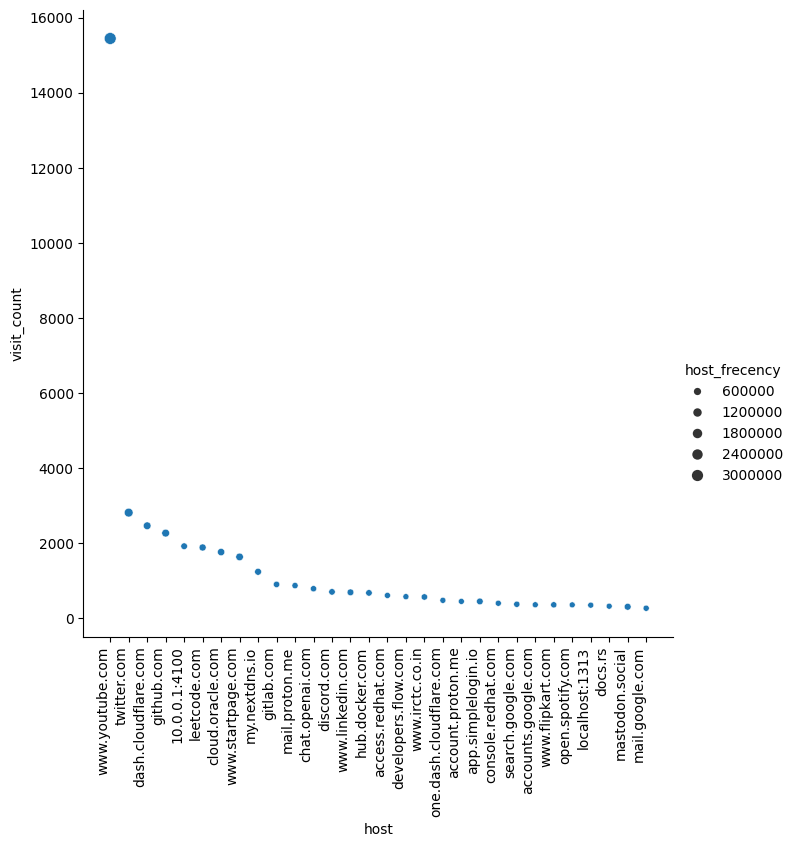

In [18]:
ax = sns.relplot(
    x="host",
    y="visit_count",
    data=modified_data.sort_values(by="visit_count", ascending=False).head(30),
    # hue="visit_TOD",
    size="host_frecency",
    height=7,
    aspect=1,
)

ax.set_xticklabels(rotation=90, ha="right")

plt.show()


In [19]:
top_30_data = modified_data.sort_values(by="visit_count", ascending=False).iloc[:10]

# 'host',	'host_frecency',	'visit_count',	'visits_morning',	'visits_afternoon',	'visits_evening',	'visits_night'

# Melt the dataset to combine "visits_morning," "visits_afternoon," etc. into a "time" column
top_30_data = top_30_data.melt(
    id_vars=["host", "visit_count", "host_frecency"],
    value_vars=["visits_morning", "visits_afternoon", "visits_evening", "visits_night"],
    var_name="visit_TOD",
    value_name="visit_count_TOD",
)

top_30_data.head()


,host,visit_count,host_frecency,visit_TOD,visit_count_TOD
0,www.youtube.com,15452.0,3398461,visits_morning,2348.0
1,twitter.com,2816.0,1346553,visits_morning,1398.0
2,dash.cloudflare.com,2466.0,764575,visits_morning,1411.0
3,github.com,2270.0,819971,visits_morning,956.0
4,10.0.0.1:4100,1921.0,297601,visits_morning,1906.0


/home/ubuntu/FDS/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


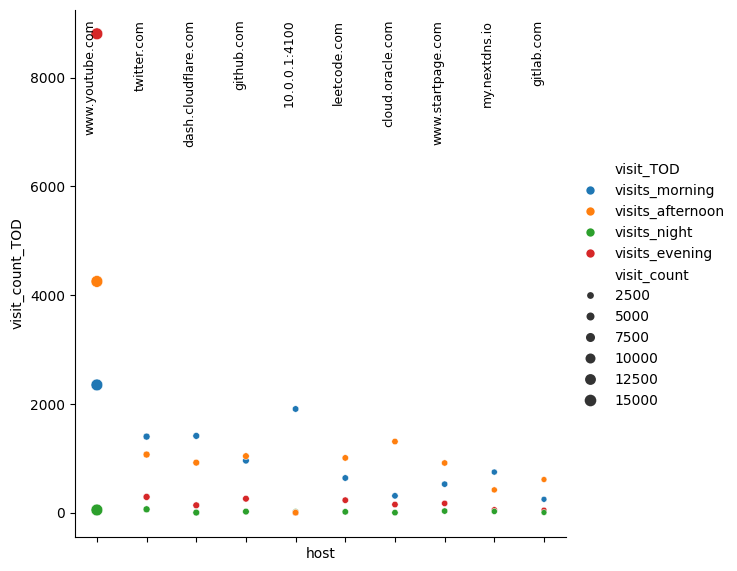

In [20]:
ax = sns.relplot(
    x="host",
    y="visit_count_TOD",
    data=top_30_data.sort_values(by="visit_count", ascending=False),
    hue="visit_TOD",
    size="visit_count",
    height=6,
    aspect=1,
    legend="brief",
)

ax.set_xticklabels(rotation=90, ha="right", fontsize=9, y=1)

plt.show()


<Axes: >

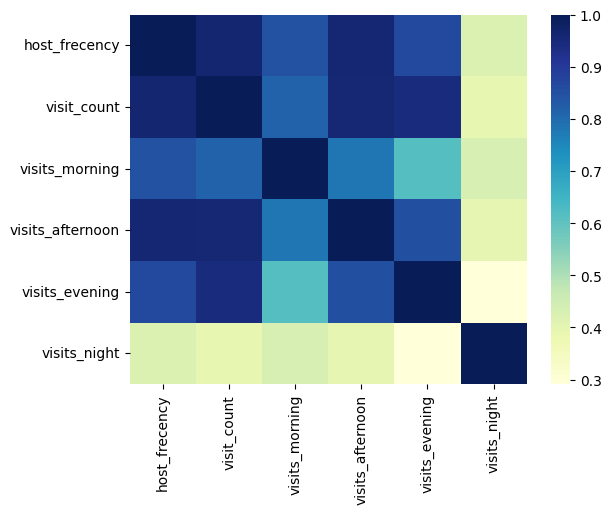

In [21]:
# 'host',	'host_frecency',	'visit_count',	'visits_morning',	'visits_afternoon',	'visits_evening',	'visits_night'
#

sns.heatmap(
    data=modified_data[
        [
            "host_frecency",
            "visit_count",
            "visits_morning",
            "visits_afternoon",
            "visits_evening",
            "visits_night",
        ]
    ].corr(),
    cmap="YlGnBu",
    # square=True,
)


In [22]:
day_names = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday",
}
for i in range(1, 8):
    modified_data = modified_data.merge(
        full_data[full_data["last_visit_date_obj"].dt.day == i]
        .groupby("host")["visit_count"]
        .sum()
        .rename(f"visits_{day_names[i]}"),
        on="host",
        how="left",
    )

modified_data.head()


,host,host_frecency,visit_count,visits_morning,visits_afternoon,visits_evening,visits_night,visits_Monday,visits_Tuesday,visits_Wednesday,visits_Thursday,visits_Friday,visits_Saturday,visits_Sunday
0,docs.fedoraproject.org,1438,23.0,17.0,4.0,2.0,0.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN
1,fedoramagazine.org,360,4.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,spins.fedoraproject.org,2163,14.0,14.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,discussion.fedoraproject.org,1060,12.0,7.0,5.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,3.0,NaN
4,forums.fedoraforum.org,214,2.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN


In [23]:
modified_data.reset_index(inplace=True)
modified_data.drop("index", axis=1, inplace=True)

modified_data.head()


,host,host_frecency,visit_count,visits_morning,visits_afternoon,visits_evening,visits_night,visits_Monday,visits_Tuesday,visits_Wednesday,visits_Thursday,visits_Friday,visits_Saturday,visits_Sunday
0,docs.fedoraproject.org,1438,23.0,17.0,4.0,2.0,0.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN
1,fedoramagazine.org,360,4.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,spins.fedoraproject.org,2163,14.0,14.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,discussion.fedoraproject.org,1060,12.0,7.0,5.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,3.0,NaN
4,forums.fedoraforum.org,214,2.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN


In [24]:
top_30_data = modified_data.sort_values(by="visit_count", ascending=False).iloc[5:21]

# 'host',	'host_frecency',	'visit_count',	'visits_morning',	'visits_afternoon',	'visits_evening',	'visits_night'

# Melt the dataset to combine "visits_morning," "visits_afternoon," etc. into a "time" column
top_30_data = top_30_data.melt(
    id_vars=["host", "visit_count", "host_frecency"],
    value_vars=[f"visits_{i}" for i in day_names.values()],
    var_name="visit_weekday",
    value_name="visit_count_weekday",
)

top_30_data.head()


,host,visit_count,host_frecency,visit_weekday,visit_count_weekday
0,leetcode.com,1887.0,484116,visits_Monday,97.0
1,cloud.oracle.com,1765.0,576082,visits_Monday,22.0
2,www.startpage.com,1636.0,710192,visits_Monday,60.0
3,my.nextdns.io,1239.0,390443,visits_Monday,NaN
4,gitlab.com,903.0,176531,visits_Monday,30.0


/home/ubuntu/FDS/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


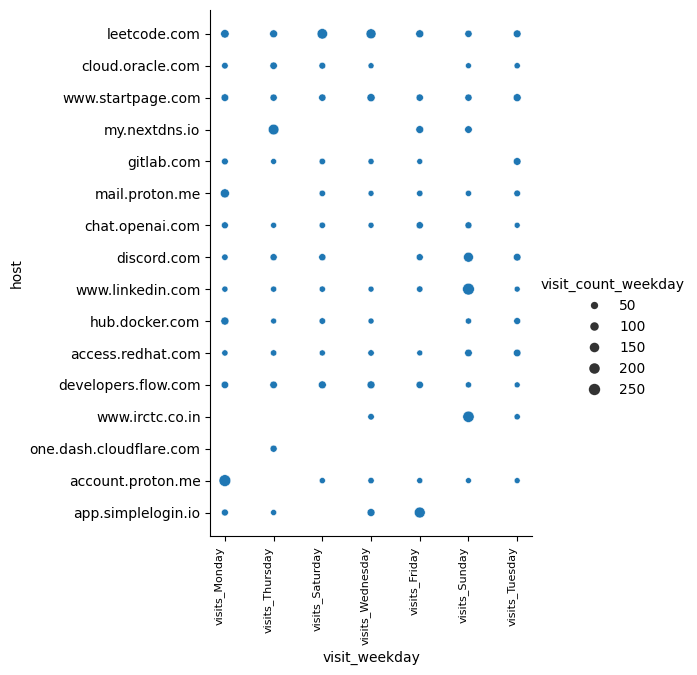

In [27]:
ax = sns.relplot(
    x="visit_weekday",
    y="host",
    data=top_30_data.sort_values(by="visit_count", ascending=False),
    # hue="visit_weekday",
    size="visit_count_weekday",
    height=6,
    aspect=1,
    legend="brief",
)

ax.set_xticklabels(rotation=90, ha="right", fontsize=8, y=0)

plt.show()
